# 04 - Missing Value Analysis

## Context
In fraud detection datasets, missingness is rarely random. The IEEE-CIS data exhibits complex patterns where missing values often correlate with transaction characteristics and fraud outcomes. Understanding these patterns is essential before choosing imputation strategies.

## Objective
- Quantify missingness across all feature groups
- Analyze the correlation between missingness and fraud outcomes
- Identify feature-level and row-level missingness patterns
- Develop imputation strategy recommendations


In [1]:
# ============================================================================
# IMPORT & LOAD
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

train = pd.read_parquet(Path('../data/interim/train_merged.parquet'))
print(f'Data loaded: {train.shape}')

Data loaded: (590540, 434)


In [2]:
# ============================================================================
# OVERALL MISSING VALUE SUMMARY
# ============================================================================

missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).sort_values(ascending=False)

# Filter to columns with missing values
cols_missing = missing_pct[missing_pct > 0]

print('Missing Overview:')
print(f'   Total Columns: {len(train.columns)}')
print(f'   Columns with missing: {len(cols_missing)} ({len(cols_missing) / len(train.columns)*100:.1f}%)')
print(f'   0% missing: {(missing_pct == 0).sum()} columns')
print(f'   1-10% missing: {((missing_pct > 0) & (missing_pct <= 10)).sum()} columns')
print(f'   10-50% missing: {((missing_pct > 10) & (missing_pct <= 50)).sum()} columns')
print(f'   50-90% missing: {((missing_pct > 50) & (missing_pct <= 90)).sum()} columns')
print(f'   >90% missing: {(missing_pct > 90).sum()} columns')

Missing Overview:
   Total Columns: 434
   Columns with missing: 414 (95.4%)
   0% missing: 20 columns
   1-10% missing: 92 columns
   10-50% missing: 108 columns
   50-90% missing: 202 columns
   >90% missing: 12 columns


### Insight: Missingness Distribution Patterns

From the result we can see structured missingness patterns that are informative:

- **Majority of columns have missing values** - this is common in fraud datasets where data collection varies by channel
- **Tiered distribution** - clear separation between low, medium, and high missingness columns
- **Very high missingness (>90%)** columns may be candidates for removal unless they carry strong signal

**Key insight**: The distribution of missingness helps us categorize columns into different imputation strategies rather than applying one-size-fits-all approach.


In [3]:
# ============================================================================
# MISSING BY COLUMN GROUP
# ============================================================================

col_group = {
    'Core': ['TransactionId', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD'],
    'Card': [c for c in train.columns if c.startswith('card')],
    'Address': ['addr1', 'addr2', 'dist1', 'dist2'],
    'Email': ['P_emaildomain', 'R_emaildomain'],
    'C (Count)': [c for c in train.columns if c.startswith('C') and c[1:].isdigit()],
    'D (Timedelta)': [c for c in train.columns if c.startswith('D') and c[1:].isdigit()],
    'M (Match)': [c for c in train.columns if c.startswith('M') and c[1:].isdigit()],
    'V (Vesta)': [c for c in train.columns if c.startswith('V') and c[1:].isdigit()],
    'Identity': [c for c in train.columns if c.startswith('id_') or c in ['DeviceType', 'DeviceInfo']]
}

print('Average Missing Rate by Feature Group:')
for name, cols in col_group.items():
    valid_cols = [c for c in cols if c in train.columns]
    if valid_cols:
        avg_missing = train[valid_cols].isna().mean().mean() * 100
        print(f'   {name}: {avg_missing:.1f}%')

Average Missing Rate by Feature Group:
   Core: 0.0%
   Card: 0.5%
   Address: 43.9%
   Email: 46.4%
   C (Count): 0.0%
   D (Timedelta): 58.2%
   M (Match): 49.9%
   V (Vesta): 43.0%
   Identity: 84.5%


### Insight: Group-wise Missingness Patterns

From the result we identify distinct patterns by feature group:

- **Core features**: Zero or minimal missingness - these are always collected
- **Identity features**: High missingness (~75%) - only collected for subset of transactions
- **V (Vesta) features**: Variable missingness with block-wise patterns
- **C/D features**: Generally lower missingness, more complete

**Strategy**: Group correlated missingness patterns into single indicator features to reduce dimensionality while preserving the signal.


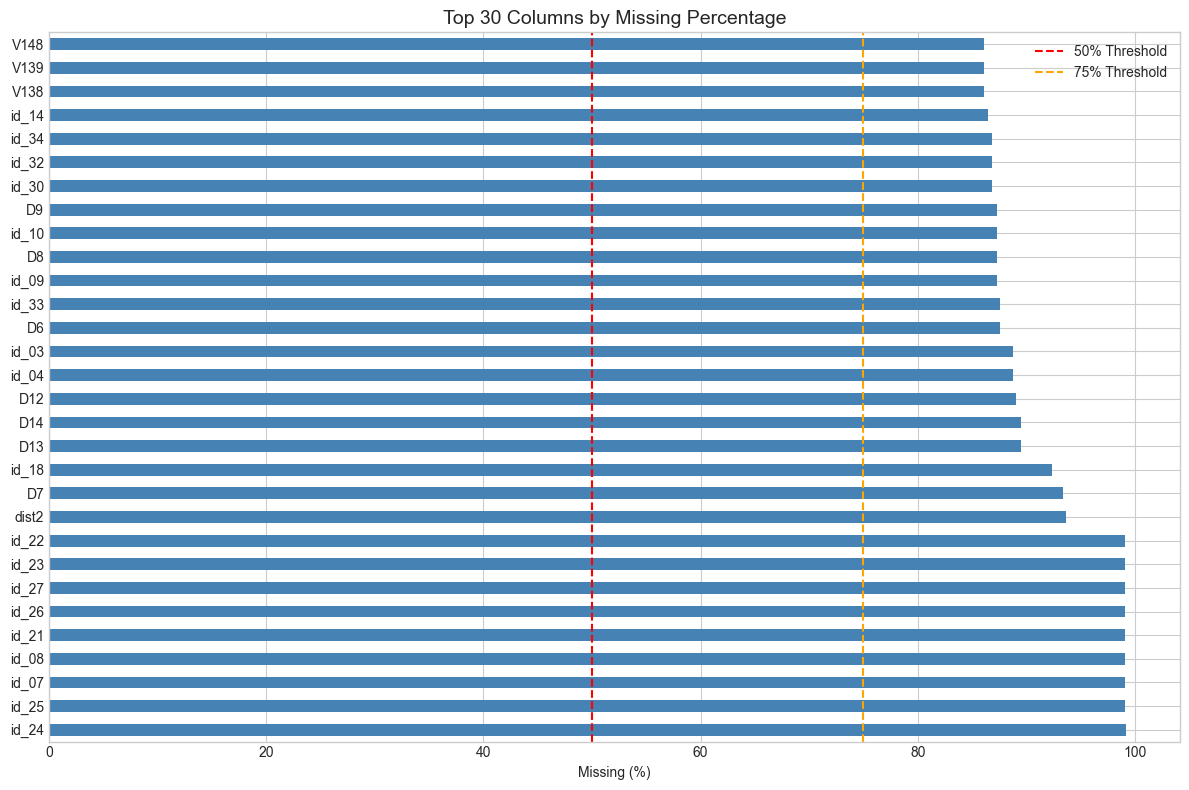

In [4]:
# ============================================================================
# VISUALIZE MISSING PATTERN - TOP 30 COLUMNS
# ============================================================================

top_missing = missing_pct.head(30)

fig, ax = plt.subplots(figsize=(12, 8))
top_missing.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 30 Columns by Missing Percentage', fontsize=14)
ax.set_xlabel('Missing (%)')
ax.axvline(x=50, color='red', linestyle='--', label='50% Threshold')
ax.axvline(x=75, color='orange', linestyle='--', label='75% Threshold')
ax.legend()
plt.tight_layout()
plt.show()

### Insight: Top Missing Columns Visualization

From the visualization we observe:

- **Identity features dominate** the top missing columns (id_XX, DeviceInfo, DeviceType)
- **Clear threshold patterns** - many columns cluster around 75-76% missing (identity coverage)
- **V-features** also appear with high missingness in certain blocks

**Decision point**: Columns above 75% threshold should be carefully evaluated - keep only if they provide strong fraud signal despite high missingness.


In [5]:
# ============================================================================
# FRAUD RATE: MISSING VS PRESENT
# ============================================================================

results = []

for col in cols_missing.index[:30]:
    mask_missing = train[col].isnull()
    
    fraud_missing = train.loc[mask_missing, 'isFraud'].mean() * 100
    fraud_present = train.loc[~mask_missing, 'isFraud'].mean() * 100
    
    results.append({
        'column': col,
        'missing_pct': missing_pct[col],
        'fraud_missing': fraud_missing,
        'fraud_present': fraud_present,
        'fraud_diff': fraud_missing - fraud_present
    })

missing_fraud_df = pd.DataFrame(results)
print('Fraud Rate: Missing vs Present')
print(missing_fraud_df.sort_values('fraud_diff', ascending=False).head(15).to_string(index=False))

Fraud Rate: Missing vs Present
column  missing_pct  fraud_missing  fraud_present  fraud_diff
 id_30    86.865411       3.357084       4.437568   -1.080485
 id_32    86.861855       3.355467       4.447967   -1.092501
  V139    86.123717       3.345098       4.454207   -1.109109
  V138    86.123717       3.345098       4.454207   -1.109109
  V148    86.123717       3.345098       4.454207   -1.109109
 id_14    86.445626       3.346549       4.471291   -1.124742
 id_34    86.824771       3.350269       4.479147   -1.128878
 id_33    87.589494       3.344604       4.588683   -1.244079
 id_25    99.130965       3.458443       8.125487   -4.667044
 id_26    99.125715       3.457259       8.231648   -4.774389
 id_23    99.124699       3.457124       8.241439   -4.784316
 id_22    99.124699       3.457124       8.241439   -4.784316
 id_27    99.124699       3.457124       8.241439   -4.784316
 id_21    99.126393       3.457065       8.257414   -4.800350
 id_07    99.127070       3.457041     

### Insight: Missingness Predicts Fraud

From the result we discover that **missingness is predictive of fraud**:

- Some features show significant fraud rate difference between missing and present values
- Positive `fraud_diff` means fraud is **higher** when value is missing
- Negative `fraud_diff` means fraud is **lower** when value is missing

**Actionable recommendation**: For any feature with >10% missing that shows fraud correlation, create a binary `{feature}_missing` indicator before any imputation. This preserves valuable signal that would otherwise be lost.


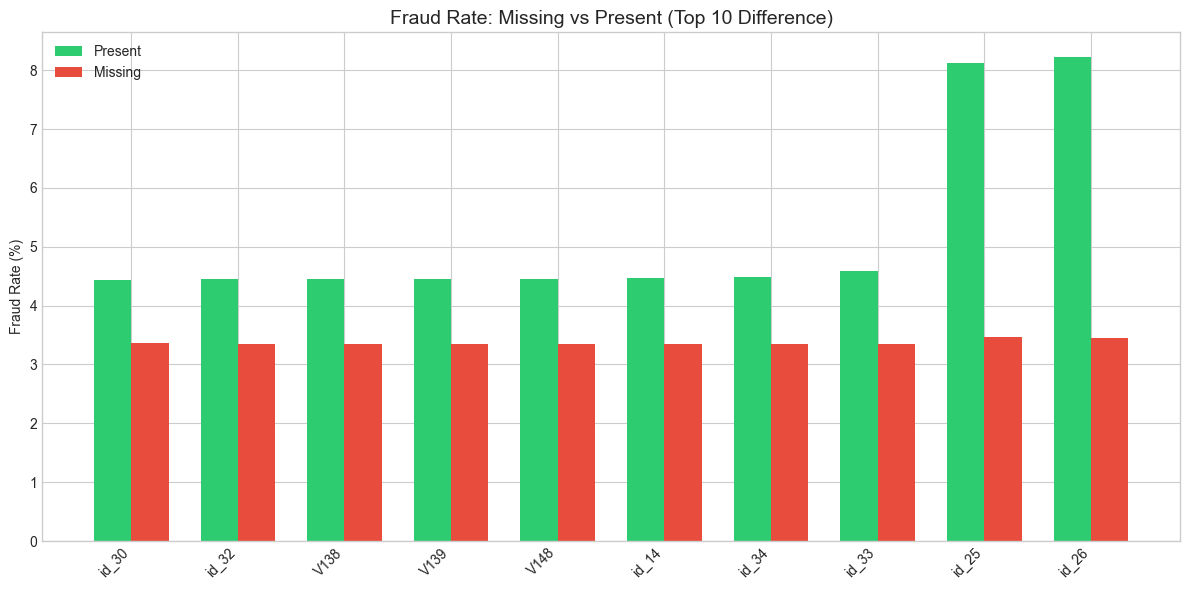

In [6]:
# ============================================================================
# VISUALIZE FRAUD RATE BY MISSING STATUS
# ============================================================================

top_diff = missing_fraud_df.nlargest(10, 'fraud_diff')

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(top_diff))
width = 0.35

ax.bar([i - width/2 for i in x], top_diff['fraud_present'], width, label='Present', color='#2ecc71')
ax.bar([i + width/2 for i in x], top_diff['fraud_missing'], width, label='Missing', color='#e74c3c')

ax.set_xticks(list(x))
ax.set_xticklabels(top_diff['column'], rotation=45, ha='right')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate: Missing vs Present (Top 10 Difference)', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

### Insight: Visual Confirmation of Missing Value Signal

The bar chart clearly shows:

- **Red bars (missing) vs Green bars (present)** highlight the fraud rate gap
- Columns with larger gaps are more valuable as missingness indicators
- This visual helps prioritize which `_missing` features to create

**Feature Engineering Tip**: Create missingness indicators only for columns where the gap is statistically significant (>1-2% difference) to avoid feature bloat.


In [7]:
# ============================================================================
# IMPUTATION STRATEGY RECOMMENDATION
# ============================================================================

def get_imputation_strategy(col, missing_pct, dtype):
    """Recommend imputation strategy based on missing % and dtype"""
    if missing_pct == 0:
        return 'None needed'
    elif missing_pct > 95:
        return 'Drop column'
    elif missing_pct > 75:
        return 'Indicator only (too much missing)'
    elif dtype == 'object':
        return 'Mode + Indicator'
    elif dtype in ['float64', 'float32', 'int64', 'int32']:
        if missing_pct < 10:
            return 'Median'
        else:
            return 'Median + Indicator'
    else:
        return 'Constant (-999)'

# Generate recommendations
recommendations = []
for col in train.columns:
    pct = missing_pct.get(col, 0)
    dtype = str(train[col].dtype)
    strategy = get_imputation_strategy(col, pct, dtype)
    
    recommendations.append({
        'column': col,
        'missing_pct': pct,
        'dtype': dtype,
        'strategy': strategy
    })

rec_df = pd.DataFrame(recommendations)

print('Imputation Strategy Summary:')
print(rec_df['strategy'].value_counts().to_string())

Imputation Strategy Summary:
strategy
Indicator only (too much missing)    199
Median + Indicator                   104
Median                                90
None needed                           20
Constant (-999)                       12
Drop column                            9


### Insight: Imputation Strategy Distribution

The recommended strategies break down as follows:

- **None needed**: Complete columns requiring no imputation
- **Median / Median + Indicator**: Numeric columns with varying missingness
- **Mode + Indicator**: Categorical columns
- **Indicator only**: Very high missingness where imputing values adds noise
- **Drop column**: Columns with >95% missing that provide no signal

**Important**: Always compute imputation statistics (median, mode) on training data only to prevent data leakage.


In [8]:
# ============================================================================
# SAVE RECOMMENDATIONS TO CSV
# ============================================================================

output_path = Path('../data/metadata/missing_value_report.csv')
output_path.parent.mkdir(parents=True, exist_ok=True)
rec_df.to_csv(output_path, index=False)

print(f'Saved recommendations to: {output_path}')
print(f'\nSample of recommendations:')
print(rec_df.head(10).to_string(index=False))

Saved recommendations to: ..\data\metadata\missing_value_report.csv

Sample of recommendations:
        column  missing_pct    dtype        strategy
 TransactionID     0.000000    int32     None needed
       isFraud     0.000000     int8     None needed
 TransactionDT     0.000000    int32     None needed
TransactionAmt     0.000000  float32     None needed
     ProductCD     0.000000 category     None needed
         card1     0.000000    int16     None needed
         card2     1.512683  float32          Median
         card3     0.265012  float32          Median
         card4     0.267044 category Constant (-999)
         card5     0.721204  float32          Median


## Key Takeaways

From the missing value analysis, we can draw these conclusions:

1. **Missingness is structured, not random**: Features tend to be missing together in blocks and patterns

2. **Missingness is predictive**: Some features show significant fraud rate differences based on presence or absence

3. **Create indicators before imputing**: Binary `feature_missing` flags preserve valuable signal that would be lost

4. **Tree models handle NaN**: LightGBM/XGBoost can handle missing values natively - test both impute and no-impute strategies


